# Introduction

This file will show us the ground truth that Ernest Provided in Matlab. Hopefully we can automate it a bit futher than this:

Previously we had mentioned about the ability for us to work with expectation across paths. This is a general case of the approach that Ernest
showed us in the previous meeting. 
Let us begin with:
$$
\begin{align*}
P(\text{error} | \Delta) &= \sum_{\rho\in \mathcal{P}} P(\epsilon , \rho | \Delta)\\
    &=\sum_{\rho\in \mathcal{P}} P(\epsilon | \rho , \Delta)P(\rho | \Delta)\\
    &=\sum_{\rho\in \mathcal{P}} P(\epsilon | \rho , \Delta)P_\Delta(\rho)\\
    &=\mathbb{E}\left[P(\epsilon | \rho , \Delta)\right]\\
\end{align*}
$$

Alas we obtain an expection of error $\epsilon$ over all the possible paths $\rho$. 

Let's expand each term for binary hypothesis testing as follows:
$$
\begin{align}
P(\epsilon | \rho, \Delta) &= P(\epsilon_{I} | \rho, \Delta) + P(\epsilon_{II} | \rho, \Delta)\\
    &= P(\hat{H} = 0 , H^*=1| \rho, \Delta) + P(\hat{H} = 1 , H^*=0| \rho, \Delta)\\
\end{align}
$$

A critical observation to be made here is that $\hat{H}|\rho \perp H^*|\rho$. This is because at the moment that we have observed our path $\rho$ the decision function collapases and becomes completely determined and independent of the hypothesis. 
Furthermore, the probability of selecting a hypothesis is such that $P(\hat{H}=i) \in \{0,1\}$. We thus end up with 
$$
\begin{align}
P(\epsilon|\rho,\Delta) &= P(\hat{H} = 0 | \rho, \Delta) P(H^* = 1 | \rho, \Delta) + P(\hat{H} = 1 | \rho, \Delta) P(H^* = 0 | \rho, \Delta)\\
    &= P(\hat{H} = 0 | \rho, \Delta) P(H^* = 1 | \rho, \Delta) + P(\hat{H} = 1 | \rho, \Delta) P(H^* = 0 | \rho, \Delta)\\
    &= P(\hat{H} = i | \rho, \Delta) P(H^* = j | \rho, \Delta) \\
    &= P(H^* = j | \rho, \Delta) \\
\end{align}
$$
Where only one term will be non-zero, the one where $P(\hat{H}|\rho, \Delta) = 1$



WIth Ernest's Derivation we have:

$$
\begin{align*}
P(\epsilon| \rho, \Delta) &= P(H^* = j | \rho, \Delta) =\frac{P(H^*=j, \rho|\Delta)}{P(\rho | \Delta)}\\
    &=\frac{P(\rho|H^*=j,\Delta)P(H^*=h|\Delta)}{P(\rho | \Delta)}\\
    &=\frac{P^{(j)}_\Delta(\rho)\frac{1}{|\mathcal{H}|}}{P(\rho | \Delta)}
\end{align*}
$$

Notice that the only stochasticity in this system comes from the prior for the hypotheses $\{\mathcal{H}_i\}^N$



Now hhere is where i am not entirely sure about my derivation. 

Tying it all together we have 

$$
\begin{align}
P(\epsilon| \Delta) &= \mathbb{E}\left[P(\epsilon|p,\Delta)\right]\\
    &= \mathbb{E}\left[\frac{P^{(j)}_\Delta(\rho)\frac{1}{|\mathcal{H}|}}{P(\rho | \Delta)}\right]
\end{align}
$$

# Lets Test This with Code

In [2]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import datetime
import argparse
from sklearn.metrics import roc_curve
from math import factorial
from scipy.linalg import expm
import sp_sims
from sp_sims.simulators.stochasticprocesses import *
from sp_sims.statistics.statistics import *
from sp_sims.estimators.algos import *
from IPython.display import clear_output
from sp_sims.sanitycheck.truebirthdeath import *
#from sp_sims.utils.utils import *
import random
from tqdm import tqdm
from time import sleep
import time

In [200]:
import importlib
importlib.reload(sp_sims.simulators.stochasticprocesses)
importlib.reload(sp_sims.statistics.statistics)

<module 'sp_sims.statistics.statistics' from '/Users/rac716/Research/RL_RateOptimization/sp_sims/statistics/statistics.py'>

In [75]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prepping

In [3]:
# We may change args here:
class Args:
  xres = 100
  length = 10000
  max_samples = 1000 # Mostly to keep computational costs down.
  state_limit = 1#Inclusive
  init_state = 0
  num_samples =2
  detection_guesses =1000
args = Args()

In [4]:
# Some Util Functions
def take_a_guess(tape, p0, p1):
    num = 0
    denum = 0
    # num = 1
    # denum = 1
    for i in range(len(tape)-1):
        from_state = tape[i]
        to_state = tape[i+1]
        # num  *= p0[from_state,to_state]
        # denum *= p1[from_state,to_state]
        num += np.log(p0[from_state,to_state])
        denum += np.log(p1[from_state,to_state])

    return 0 if num > denum else 1
def return_ls(tape, p0, p1):
    num = 1
    denum = 1
    for i in range(len(tape)-1):
        from_state = tape[i]
        to_state = tape[i+1]
        num  *= p0[from_state,to_state]
        denum *= p1[from_state,to_state]
    return num,denum
def stats_for_single_22paths(sts,hts,samp_rate, p0s, p1s, path = [0,0]):
    # Take all Paths 
    # This count how many i->j transitiosn per hypothesis are encountered
    hyp_counts = np.zeros(2) # 2 For 2 number of hypothesis
    # Dice them for sampling rates
    for i,p in enumerate(sts):
        idx_true_hyp = true_values[i]
        sampled_tape = quick_sample(samp_rate, sts[i],hts[i])

        count = ((tmpSampTape[:-1] == path[0]) & (tmpSampTape[1] == path[1])).sum()
        hyp_counts[idx_true_hyp] += count

    return hyp_counts


In [5]:
# Some Setup 
#rates0 = {"lam": 2/10,"mu":4/10}
#rates1 = {"lam": 100/10,"mu":120/10}
np.random.seed(int(time.time()))
rates0 = {"lam": 1,"mu":1.5}
rates1 = {"lam": 0.1,"mu":0.2}
rates = [rates0,rates1]
samp_rates = np.logspace(-3,6,args.xres, base=2)
tgm0 = np.array([[-rates0['lam'],rates0['lam']],[rates0['mu'],-rates0['mu']]])
tgm1 = np.array([[-rates1['lam'],rates1['lam']],[rates1['mu'],-rates1['mu']]])


hts, sts = ([],[])
last_times  = []
true_values = np.random.choice(2,args.detection_guesses)
# Generate The Tapes
for i in range(args.detection_guesses):
    roe = RaceOfExponentials(args.length,rates[true_values[i]],state_limit=args.state_limit)
    holdTimes_tape, state_tape = roe.generate_history(args.init_state)
    hts.append(holdTimes_tape);
    sts.append(state_tape)
    last_times.append(np.cumsum(holdTimes_tape)[-1])

# Preparation of True Probabilities
true_p0s = []
true_p1s = []
# Crete all the *known* probability functions.
for srIdx, cur_samp_rate in enumerate(samp_rates):
    true_p0s.append(expm(tgm0*(1/cur_samp_rate)))
    true_p1s.append(expm(tgm1*(1/cur_samp_rate)))


# Generation of Paths

## For a Particular Path $(0\to0)$

In [ ]:
# This is all we Need
fixed_state_tape = [0,0]
fixed_true_values= np.random.choice(2,args.detection_guesses)
fixed_guesses = np.zeros((len(samp_rates), args.detection_guesses))

# Take Our Guesses
guesses = np.zeros((len(samp_rates), args.detection_guesses))
for i in tqdm(np.arange(args.detection_guesses)):
    # Prepare for Decimation: First sample with the quickest rate. -> Smallest Unit of Time Interval
    sampled_tape = fixed_state_tape # Yes, a bit hacky
    # Go Over the 
    for srIdx, cur_samp_rate in enumerate(samp_rates):
        # Fetch Values for Current Rate
        true_p0 = true_p0s[srIdx]
        true_p1 = true_p1s[srIdx]
        true_ps = [true_p0,true_p1]
        
        # How many of the baseline intervals fit into the slow rate interval
        decimateInterval = int(base_samp_rate/cur_samp_rate)
        tmpSampTape = sampled_tape[0::decimateInterval]
        ############################################
        # Limit the NUmebr of Samples
        ############################################
        fixed_guesses[srIdx, i] = take_a_guess(sampled_tape, true_p0, true_p1)
        l0, l1 = return_ls(sampled_tape, true_p0, true_p1) # Shall not use this as it results in very small quantities
        # l0 = return_lr(limited_sampled_tape, true_p0, true_p1)
        # l1 = 1
        ###################################################################
        # Add Per Sample
        #l0Vcs[srIdx, i] = l0
        #l1cs[srIdx, i] = l1

## For Any Path

In [8]:
########################################
# Generation
########################################
base_samp_rate = samp_rates[-1]
guesses = np.zeros((len(samp_rates), args.detection_guesses))
# LIkelihoods in 2D. On First Axis Sampling Rates, On Second Axis number of guesses
l0cs = np.zeros((len(samp_rates), args.detection_guesses))
l1cs = np.zeros((len(samp_rates), args.detection_guesses))
# Go Over the Detection Guesses
path_hyp_counts = np.zeros((len(samp_rates),2)) # 2 for number of hypothesis
totpath_hyp_counts = np.zeros((len(samp_rates),2)) # 2 for number of hypothesis
path_of_interest = [0,0]
print("Sampling at fastest rate : ", base_samp_rate)
sampled_tapes = (quick_sample(base_samp_rate, sts[0],hts[0]), quick_sample(base_samp_rate, sts[1],hts[1]))
#sampled_tapes = (simple_sample(base_samp_rate, sts[0],hts[0],max_samples=args.max_samples), simple_sample(base_samp_rate, sts[1],hts[1], max_samples=args.max_samples))
shortest_path =  np.inf
print("Decimating and collecting stats...")
#for i in tqdm(np.arange(args.detection_guesses)):

Sampling at fastest rate :  64.0
Decimating and collecting stats...


In [9]:
# Do Decimation here.
for i in np.arange(args.detection_guesses):
    idx_true_hyp = true_values[i]
    sampled_tape = sampled_tapes[idx_true_hyp]
    # Prepare for Decimation: First sample with the quickest rate. -> Smallest Unit of Time Interval
    # Go Over the 
    for srIdx, cur_samp_rate in enumerate(samp_rates):
        # Fetch Values for Current Rate
        true_p0 = true_p0s[srIdx]
        true_p1 = true_p1s[srIdx]
        true_ps = [true_p0,true_p1]
        
        # How many of the baseline intervals fit into the slow rate interval
        decimateInterval = int(base_samp_rate/cur_samp_rate)
        tmpSampTape = sampled_tape[0::decimateInterval]
        shortest_path = np.min([len(tmpSampTape), shortest_path])


        tmpSampTape = tmpSampTape[:1000]

        # Count How much of each specific path we have
        count = ((tmpSampTape[:-1] == path_of_interest[0]) & (tmpSampTape[1:] == path_of_interest[1])).sum()
        totpath_hyp_counts[srIdx,idx_true_hyp] += len(tmpSampTape)-1
        path_hyp_counts[srIdx,idx_true_hyp] += count

# Some Stats 
print("Shortest Length of path is: ",shortest_path)

Shortest Length of path is:  9199.0


## Debugging/Stats

In [146]:
print("The sampled tapes for each 0 and 1 have different shapes")
print(sampled_tapes[0].shape)
print(sampled_tapes[1].shape)

The sampled tapes for each 0 and 1 have different shapes
(213214,)
(1909756,)


Hyp0 count is: 349 out of 832 total transitions
Hyp1 count is: 4615 out of 832 total transitions


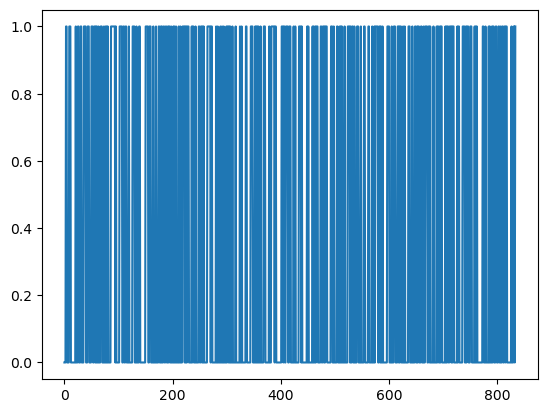

In [140]:
# Let me see both of these
di = int(base_samp_rate/1)
meep0 = sampled_tapes[0][0::di]
meep1 = sampled_tapes[1][0::di]
plt.plot(np.linspace(0,833,833), meep0)
count0 = ((meep0[:-1] == path_of_interest[0]) & (meep0[1:] == path_of_interest[1])).sum()
count1 = ((meep1[:-1] == path_of_interest[0]) & (meep1[1:] == path_of_interest[1])).sum()
print("Hyp0 count is: {} out of {} total transitions".format(count0,832))
print("Hyp1 count is: {} out of {} total transitions".format(count1,832))
plt.show()

This is for parameters :  {'lam': 0.1, 'mu': 0.2}
Printing Frome:  1984


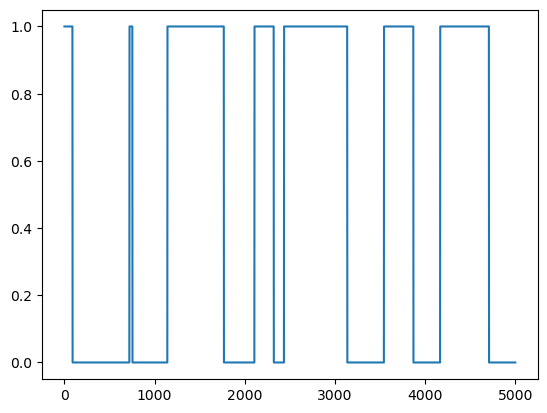

In [120]:
print("This is for parameters : ", rates[true_values[-1]])
window = 5000
init_place = int(np.random.choice(len(tmpSampTape)-window,1))
print("Printing Frome: ", init_place)
rango = tmpSampTape[init_place:init_place+window]
plt.plot(range(len(rango)), rango)
plt.show()

# Data Processing

## Single Path Error Probability

At this point we want to test the single error equation that we derived before:

$$
P(\epsilon| \rho, \Delta) =\frac{P^{(j)}_\Delta(\rho)\frac{1}{|\mathcal{H}|}}{P(\rho | \Delta)}
$$


In [ ]:
# For A single Path
fixed_fprs = []
fixed_fnrs = []

# For each Guess Run, what is the correct hypothesis.
num_tnegs = np.sum(true_values == 0)#TN + FP
num_tpos = np.sum(true_values == 1)#TP + FN

for srIdx, cur_samp_rate in enumerate(samp_rates):
    # Will be fixed for a fixed path
    guesses = fixed_guesses[srIdx]

    hits_index = (true_values == guesses)
    tp = (true_values[hits_index] == 1).sum()
    tn = (true_values[hits_index] == 0).sum()
    
    # Type I and II errors.
    fixed_fprs.append((num_tnegs-tn)/(num_tnegs))
    fixed_fnrs.append((num_tpos-tp)/(num_tpos))# Type 2 Error


In [ ]:
# Lets start graphing:
print(fixed_fprs)
print(fixed_fnrs)

100%|██████████| 100/100 [00:00<00:00, 588261.43it/s]


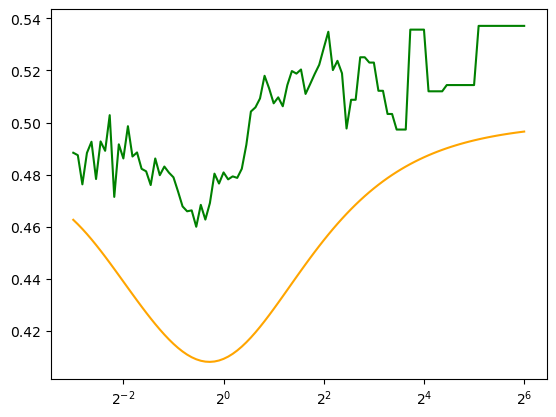

In [10]:
# Graphy Graph

#P(error | path, \Deleta)
tperror = np.zeros(len(samp_rates))
bloop = []
numerical_errors = []
# For Now we will focus on Type I error  because H1 should always be preferred. 
for i in tqdm(np.arange(len(samp_rates))):
    sr = samp_rates[i]
    #num = true_p1s[i][0,0] if true_p0s[i][0,0] > true_p1s[i][0,0] else true_p0s[i][0,0]
    num = true_p0s[i][0,0] 
    denum = true_p0s[i][0,0] + true_p1s[i][0,0]
    tperror[i] = num/denum


# Get the Numerical Erros
numerical_errors = (path_hyp_counts[:,0]) / (path_hyp_counts).sum(axis=1)

plt.plot(samp_rates, numerical_errors,color='green')
plt.plot(samp_rates, tperror, color='orange')
plt.xscale('log',base=2)
#plt.ylim((0,1))
plt.show()


In [52]:
path_hyp_counts[:,0]/totpath_hyp_counts[:,0]

array([0.41176471, 0.29126214, 0.36538462, 0.36538462, 0.45714286,
       0.33018868, 0.31775701, 0.33333333, 0.2293578 , 0.44954128,
       0.41818182, 0.36936937, 0.44642857, 0.30088496, 0.42105263,
       0.35652174, 0.46086957, 0.28448276, 0.34188034, 0.30508475,
       0.31092437, 0.375     , 0.33884298, 0.27868852, 0.38211382,
       0.33870968, 0.384     , 0.37301587, 0.27559055, 0.33858268,
       0.30232558, 0.39534884, 0.30769231, 0.41984733, 0.44360902,
       0.47761194, 0.39259259, 0.34558824, 0.37956204, 0.3115942 ,
       0.25179856, 0.37142857, 0.39007092, 0.4084507 , 0.35664336,
       0.33333333, 0.27586207, 0.25342466, 0.39864865, 0.32214765,
       0.46      , 0.34437086, 0.36842105, 0.32026144, 0.32467532,
       0.29487179, 0.44585987, 0.39873418, 0.30188679, 0.35      ,
       0.37654321, 0.3803681 , 0.29268293, 0.37575758, 0.37125749,
       0.33333333, 0.34319527, 0.34502924, 0.29069767, 0.41618497,
       0.41142857, 0.42613636, 0.36158192, 0.27932961, 0.41111

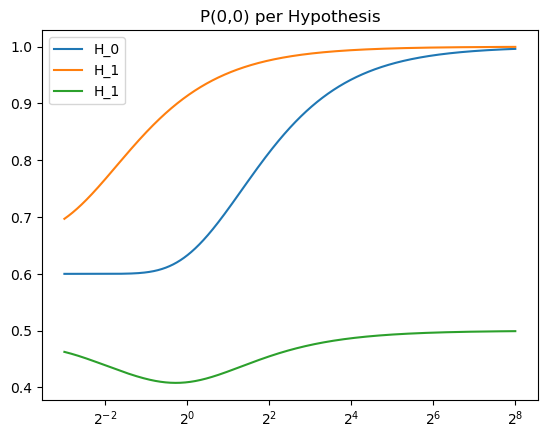

In [61]:
# See If Probabilities Change:
p00_0s = np.array([p[0,0] for p in true_p0s])
p00_1s = np.array([p[0,0] for p in true_p1s])

plt.plot(samp_rates, p00_0s, label="H_0")
plt.plot(samp_rates, p00_1s, label="H_1")
plt.plot(samp_rates, p00_0s/(p00_0s+p00_1s), label="H_1")
plt.legend()
plt.title("P(0,0) per Hypothesis")
plt.xscale('log',base=2)
plt.show()
# Clearym in our particular case H1 is superior than Hypothesis 0 for every single sampling rate. 

In [ ]:
for i,j in enumerate(samp_rates):
    clear_output(wait=True)
    print(fixed_fprs[i])
    print(fixed_guesses[i])
    print(true_p0s[i])
    print(true_p1s[i])
    sleep(0.1)

## General Path Error Probability

In [ ]:
########################################
# Process the Results
########################################
# Number of true positive and negatives
num_tnegs = np.sum(true_values == 0)#TN + FP
num_tpos = np.sum(true_values == 1)#TP + FN

# Our main stars here
fprs = [] # False Positive Rates
fnrs = [] # False Negative Rates

# At this point we have our guesses saved
# Loop through all Sampling Rates we have used
for srIdx, cur_samp_rate in enumerate(samp_rates):
    # For Plotting ROC Curve
    guess = guesses[srIdx]
    # Take likelihoods for this sampling rate
    l0c = l0cs[srIdx]
    l1c = l1cs[srIdx]

    # Hits and True Probabilities
    hits_index = (true_values == guess)
    tp = (true_values[hits_index] == 1).sum()
    tn = (true_values[hits_index] == 0).sum()

    # Correct
    sensitivities.append(tp/num_tpos)
    invspecificities.append(1-(tn/num_tnegs))

    # False Positive and Negative Rates
    fprs.append((num_tnegs-tn)/(num_tnegs))
    fnrs.append((num_tpos-tp)/(num_tpos))# Type 2 Error

    
    #This section for H0 case
    # I dont knwo why Ernest focuses on when we get it right
    # idxLocs = (true_values == 0)
    # lInterest = l0c[idxLocs]# Just get the one of interest
    lInterest = l0c

    l0s.append(np.mean(lInterest))
    v0s.append(np.std(lInterest))
    mi0s.append(np.min(lInterest))
    ma0s.append(np.max(lInterest))
    
    #This section for H1 case
    # # Again same as above
    # idxLocs = (true_values == 1)
    # lInterest = l1c[idxLocs] # Get Likelihood 1
    lInterest = l1c

    l1s.append(np.mean(lInterest))
    v1s.append(np.std(lInterest))

    mi1s.append(np.min(lInterest))
    ma1s.append(np.max(lInterest))

    num_hits = (true_values == guess).sum()
    hit_rates.append(num_hits/args.detection_guesses)


# Policy Gradient Algorithms
In this section we will implement policy gradient algorithms, and if necessary we will do PPO. 

There is nothing episodic about our run and environment. We may think of our environment as a simple bandit environmen in the sense that there is only a single step. 
However, Policy Gradients may still work in these cases. 

An extra bit of caveat that we must mention is that we work with actions in continuous space. In these cases I have read that it Bayesian Networks are used. More specficically 
we could draw actions from teh gaussian distribution. In this caswe would learn an appropriate mean and standard deviation. 

In [29]:
import torch 

## More Generally:


$$
\begin{align}
P(\epsilon|\rho,\Delta) &= \sum_i \sum_j P(\hat{H} = i | \rho, \Delta) P(H^* = j | \rho, \Delta)\\
    &= \sum_j P(H^* = j | \rho, \Delta)\\
    &= \sum_j P(H^* = j | \rho, \Delta)\\
\end{align}
$$

We may then say that 

In This file we will